In [1]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
import time
import matplotlib.pyplot as plt
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pickle

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

### Gadf


# Record Audio

In [2]:
!pip install librosa

In [3]:
def feature_extractor(sound_path, win_length_ms=25, hop_length_ms=10):
    # Load the audio file
    signal, sr = librosa.load(sound_path,sr=8000)
    # signal,sr = wavfile.read(sound_path)
    # Extract MFCCs
    win_length_samples = int(sr * win_length_ms / 1000)
    hop_length_samples = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length_samples, win_length=win_length_samples)
    # mfccs = mfcc(signal,samplerate=sr,nfft = 2048,numcep=13,nfilt=13)
    
    #Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [4]:
def preprocess(path, is_pca=0, num_pca = 2, window_length_ms=20, hop_length_ms=10):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=8000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    # samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file,window_length_ms,hop_length_ms)
    # tot= np.concatenate((a,b,c,d)).T
    tot = d.T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [5]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50,window_length_ms=20, hop_length_ms=10):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            # samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            # samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            # tot = np.concatenate((a, b, c, d)).T
            tot = d.T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

# Main Code

In [6]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

In [7]:
train_paths = ["/kaggle/input/language-recognition/Language-Recognition-VADaudio/Gujrati-Train","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Tamil-Train","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Telugu-Train"]
test_paths = ["/kaggle/input/language-recognition/Language-Recognition-VADaudio/Gujrati-Test","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Tamil-Test","/kaggle/input/language-recognition/Language-Recognition-VADaudio/Telugu-Test"]

In [8]:
import math
from scipy.stats import multivariate_normal
import numpy as np


In [9]:
class GMMNew:
    def __init__(
        self, 
        n_mixtures=120, 
        max_iter=100, 
        covar_type='full', 
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.log_likelihood_plot_list = None
        
    # get aic and bic score
    def aic_bic(self, X):
        # Get the log-likelihood
        log_likelihood = self.get_loglikelihood(X)
        
        # Calculate the number of parameters in the model
        n_params = self.n_mixtures
        
        # Calculate AIC and BIC
        aic = -2 * log_likelihood + 2 * n_params
        bic = -2 * log_likelihood + n_params * np.log(len(X))
        
        return aic, bic
    
    
    # Function to get the log likelihood
    def get_loglikelihood(self,X):
        return self.get_score(X)
    
        # Function to basically get log-likelihood data
    def get_score(self,X):
        resp = np.zeros((len(X), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian (wik) probability of a data point i to be in kth Gaussian mixture 
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * multivariate_normal(mean=self.means[i], cov=self.covs[i],allow_singular=True).pdf(X)
        return np.mean(np.log(resp.sum(axis=1)))
    
    # M Step for full covariance matrix
    def full_covar(self, X, resp):
        d = X.shape[1]
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = X - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i] += np.eye(d) * 1e-6
        return new_covs
    
    # M step for diagonal covariance matrix
    def diag_covar(self, X, resp):
        d = X.shape[1]
        new_covs = np.zeros((self.n_mixtures, d,d))
        for i in range(self.n_mixtures):
            wik = resp[:,i]
            num = wik.reshape(X.shape[0],1)*np.square(X-self.means[i])
            column_sums = np.sum(num,axis=0).reshape(1,d) # result will be (1,d) matrix
            column_sums /= np.sum(wik)
            np.fill_diagonal(new_covs[i],column_sums+1e-6) # regularisation term
        return new_covs
    
    # E step
    def e_step(self, X):
        resp = np.zeros((len(X), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * multivariate_normal(mean=self.means[i], cov=self.covs[i],allow_singular=True).pdf(X)
        # To plot the variation of log_likelihood
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        resp = resp / resp.sum(axis=1).reshape(-1, 1)
        return resp
    
    def m_step(self, X, resp):        
        # M step for alphas
        new_alphas = resp.mean(axis=0)
        
        # M step for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i].reshape(-1, 1), X).sum(axis=0) / resp[:, i].sum()
        
        # M step for covariance matrix according to type chosen
        if self.covar_type == 'full':
            new_covs = self.full_covar(X, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(X, resp)
        return new_alphas, new_means, new_covs
    
    # Fit algorithm
    def fit(self, X):
        total_iteration_time = 0
        
        start_total = time.time()
        d = X.shape[1]
        last = 0
        # To store the log lijkelihood for every iteration
        self.log_likelihood_plot_list = []
        
        # initialize means as to K means result initally
        kmeans_model =  KMeans(self.n_mixtures).fit(X)
        self.means = kmeans_model.cluster_centers_
        
        # initialize cov matrix of data point i as sample covariance matrix
        self.covs = np.zeros((self.n_mixtures, d, d))
        data_labels = kmeans_model.labels_

        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(X[data_labels == i].T+0.1)
        
        # EM - algorithm
        for epoch in range(self.max_iter):
            last = epoch
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(X)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(X, resp)
            
            # Print convergence criteria
            if (np.abs(self.alphas - alphas) < 1e-4).all() and \
               (np.abs(self.means - means) < 1e-4).all() and \
               (np.abs(self.covs - covs) < 1e-4).all():
                print("Converged at iteration:", step)
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]
        end_total = time.time()
        total_time = end_total - start_total
        print(f"Average time per iteration: {total_time / (self.max_iter):.4f} seconds")
        plt.figure(figsize=(6, 4)) 
        plt.plot(range(last), self.log_likelihood_plot_list,color='g', linewidth=2)
        plt.xlabel('Number of Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Variation of Log Likelihood for each iteration')
        plt.tight_layout()  
        plt.show()
        

# Pipeline to train the model and plot the Confusion Matrix and get metrics

In [10]:
# Function to get f1 score
def compute_f1_score(confusion_matrix):
    num_classes = len(confusion_matrix)
    f1_scores = []

    for i in range(num_classes):
        true_positive = confusion_matrix[i][i]
        false_positive = sum(confusion_matrix[j][i] for j in range(num_classes) if j != i)
        false_negative = sum(confusion_matrix[i][j] for j in range(num_classes) if j != i)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1_score)

    return f1_scores

In [11]:
# Calculate the silhoutte score
def calc_silhoutte_score(X,gmms):
    # Iterate through each data point in X and assign cluster labels
    cluster_labels_list = []
    for x in X:
        log_likelihood = [gmm.get_score(x) for gmm in gmms]  # Calculate log-likelihood for each GMM
        predicted_cluster = np.argmax(log_likelihood)  # Assign to cluster with maximum log-likelihood
        cluster_labels_list.append(predicted_cluster)

    # Convert cluster labels to numpy array
    cluster_labels = np.array(cluster_labels_list)

    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def pipeline(n_components_gmm, is_pca, num_pca, c_type='full'):
    gmms = []
    sklearn_gmms = []  # List to store scikit-learn's GMMs
    i = 0
    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']
    
    for path in train_paths:
        i += 1
        X = preprocess_folder(path, is_pca, num_pca, items=110)
        
        # Train and save your GMM
        gmm = GMMNew(n_components_gmm, 100, c_type)  # Max 100 iterations
        gmm.fit(X)
        with open(f'gmm{c_type}_{n_components_gmm}_{num_pca}_{i}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        gmms.append(gmm)
        
        # Train scikit-learn's GMM
        sklearn_gmm = GaussianMixture(n_components=n_components_gmm, covariance_type=c_type, max_iter=100)
        sklearn_gmm.fit(X)
        sklearn_gmms.append(sklearn_gmm)
        aic, bic = gmm.aic_bic(X)
        print(f"GMM Model for {class_labels[(i-1)%3]} => AIC: {aic}, BIC: {bic}")
        print(f"{class_labels[(i-1)%3]} is done")

    # Initialize confusion matrices
    confusion_matrix_gmm = np.zeros((3, 3))  # For your GMM
    confusion_matrix_sklearn = np.zeros((3, 3))  # For scikit-learn's GMM

    # Evaluate your GMM and update confusion matrix
    for idx, path in enumerate(test_paths):
        class_counts_gmm = {0: 0, 1: 0, 2: 0}
        class_counts_sklearn = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file, is_pca, num_pca)
                
                # Evaluate your GMM
                log_likelihood_gmm = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm = gmms[i]  
                    log_likelihood_gmm[i] = gmm.get_score(vector)
                
                winner_gmm = np.argmax(log_likelihood_gmm)
                class_counts_gmm[winner_gmm] += 1

                # Evaluate scikit-learn's GMM
                log_likelihood_sklearn = np.zeros(len(sklearn_gmms))
                for i in range(len(sklearn_gmms)):
                    gmm = sklearn_gmms[i]
                    log_likelihood_sklearn[i] = np.array(gmm.score(vector)).sum()

                winner_sklearn = np.argmax(log_likelihood_sklearn)
                class_counts_sklearn[winner_sklearn] += 1

        # Update confusion matrices
        for true_label, count in class_counts_gmm.items():
            confusion_matrix_gmm[idx, true_label] = count
        for true_label, count in class_counts_sklearn.items():
            confusion_matrix_sklearn[idx, true_label] = count


    # Plot confusion matrices side by side
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix_gmm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for GMM implementation')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix_sklearn, annot=True, cmap='Oranges', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix for Scikit learn implementation")

    plt.show()

    # Calculate and print accuracy and F1 scores
    accuracy_gmm = np.trace(confusion_matrix_gmm) / np.sum(confusion_matrix_gmm)
    accuracy_sklearn = np.trace(confusion_matrix_sklearn) / np.sum(confusion_matrix_sklearn)
    
    f1_scores_gmm = compute_f1_score(confusion_matrix_gmm)
    f1_scores_sklearn = compute_f1_score(confusion_matrix_sklearn)
    
    print("GMM Implementation Metrics:")
    print(f"Overall Accuracy: {accuracy_gmm*100:.2f}%")
    for idx, label in enumerate(class_labels):
        print(f"F1 Score of {label}: {f1_scores_gmm[idx]}")

    print("\nScikit-learn's GMM Metrics:")
    print(f"Overall Accuracy: {accuracy_sklearn*100:.2f}%")
    for idx, label in enumerate(class_labels):
        print(f"F1 Score of {label}: {f1_scores_sklearn[idx]}")
        

## Getting the results

Num comp:32, Num PCA:3
Average time per iteration: 0.5616 seconds


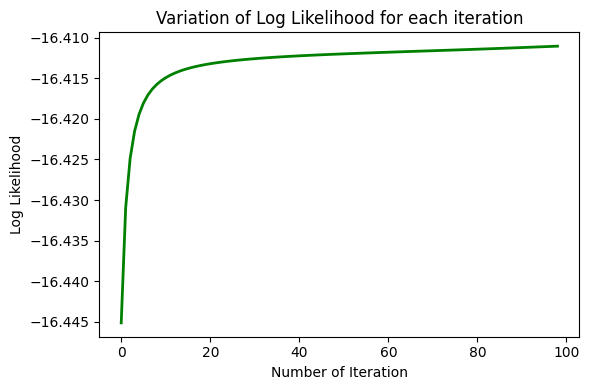

GMM Model for Gujrati => AIC: 96.82208935088303, BIC: 378.45679789369996
Gujrati is done
Average time per iteration: 0.6288 seconds


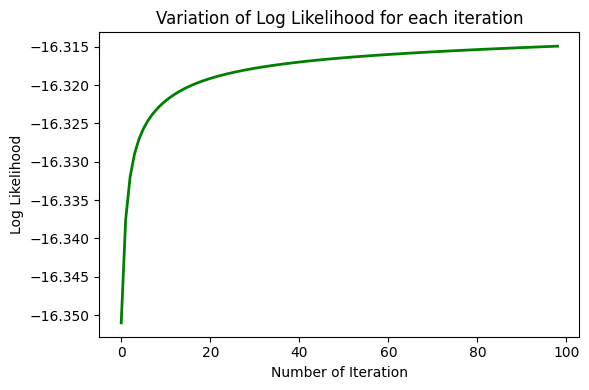

GMM Model for Tamil => AIC: 96.62977827468808, BIC: 381.79836908982406
Tamil is done
Average time per iteration: 0.5183 seconds


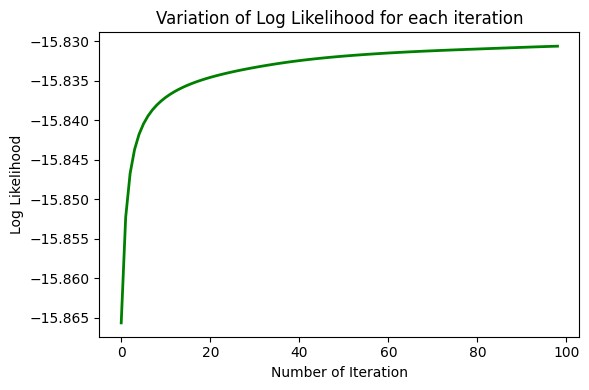

GMM Model for Telugu => AIC: 95.66115975774972, BIC: 373.69047067658033
Telugu is done


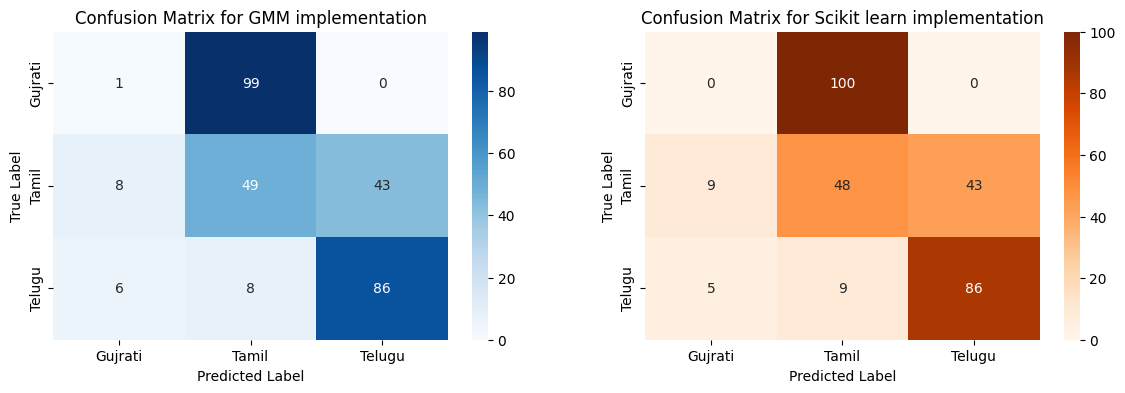

GMM Implementation Metrics:
Overall Accuracy: 45.33%
F1 Score of Gujrati: 0.017391304347826087
F1 Score of Tamil: 0.3828125
F1 Score of Telugu: 0.7510917030567684

Scikit-learn's GMM Metrics:
Overall Accuracy: 44.67%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.3735408560311284
F1 Score of Telugu: 0.7510917030567684
Num comp:64, Num PCA:3
Average time per iteration: 1.0790 seconds


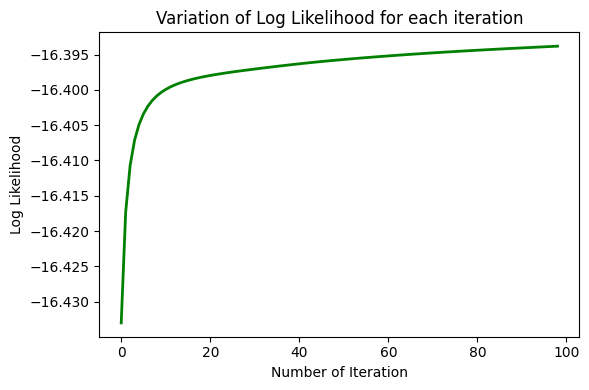

GMM Model for Gujrati => AIC: 160.78756496547717, BIC: 724.056982051111
Gujrati is done
Average time per iteration: 1.2123 seconds


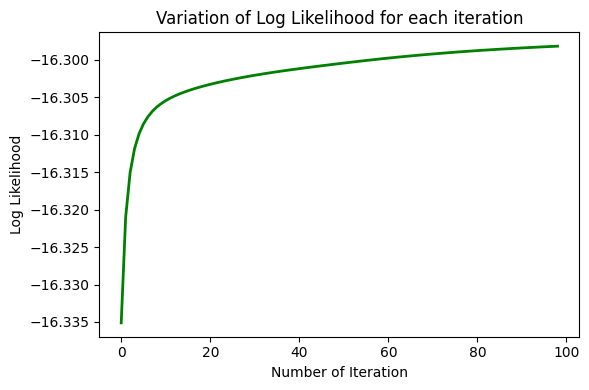

GMM Model for Tamil => AIC: 160.59630580936127, BIC: 730.9334874396333
Tamil is done
Average time per iteration: 0.9709 seconds


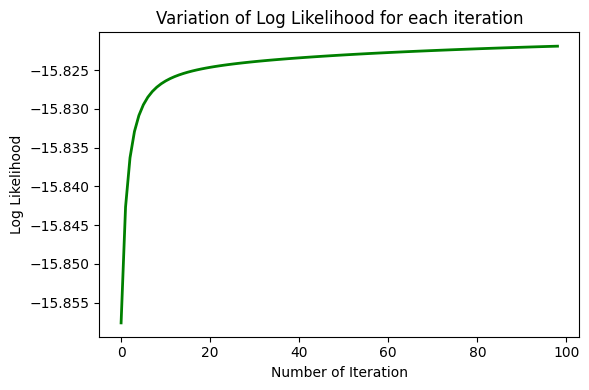

GMM Model for Telugu => AIC: 159.64377907634196, BIC: 715.7024009140032
Telugu is done


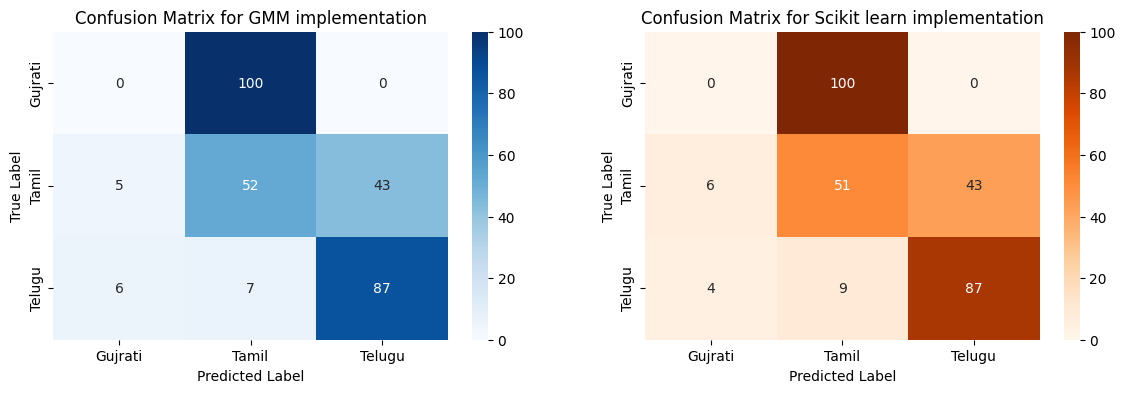

GMM Implementation Metrics:
Overall Accuracy: 46.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4015444015444016
F1 Score of Telugu: 0.7565217391304347

Scikit-learn's GMM Metrics:
Overall Accuracy: 46.00%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.3923076923076923
F1 Score of Telugu: 0.7565217391304347
Num comp:32, Num PCA:5
Average time per iteration: 0.6544 seconds


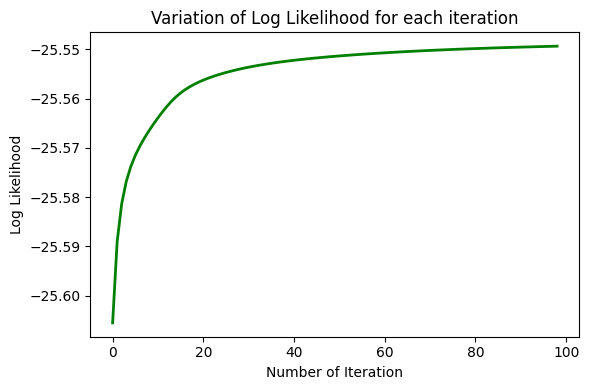

GMM Model for Gujrati => AIC: 115.09865859975173, BIC: 396.7333671425687
Gujrati is done
Average time per iteration: 0.7068 seconds


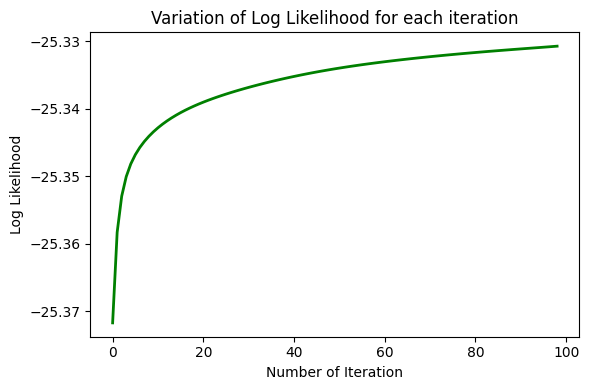

GMM Model for Tamil => AIC: 114.66132674270088, BIC: 399.8299175578369
Tamil is done
Average time per iteration: 0.5898 seconds


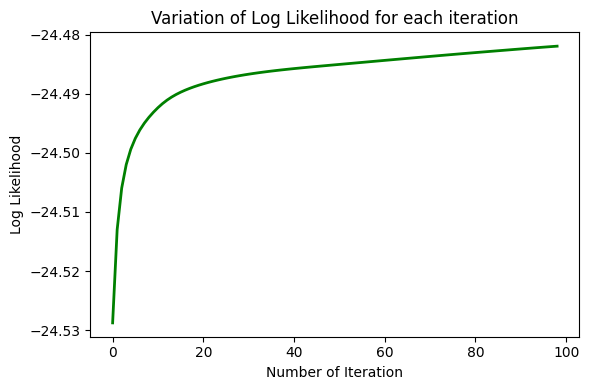

GMM Model for Telugu => AIC: 112.96374826273777, BIC: 390.99305918156836
Telugu is done


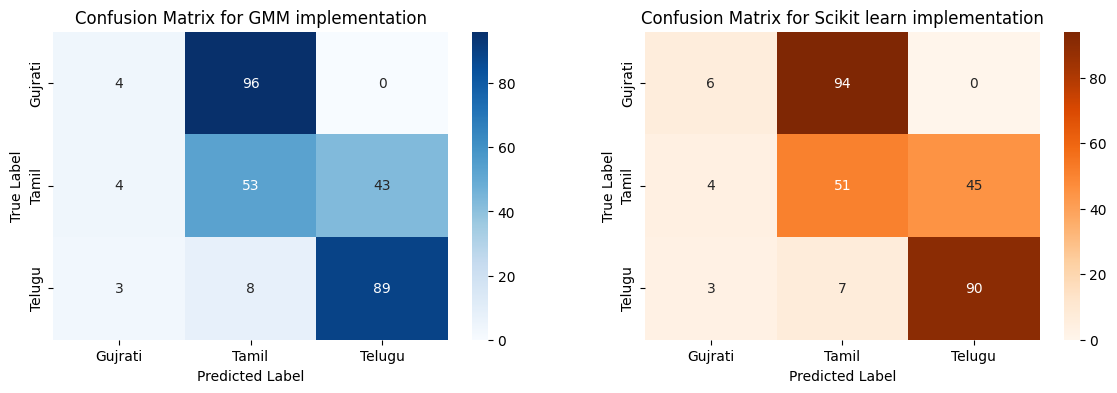

GMM Implementation Metrics:
Overall Accuracy: 48.67%
F1 Score of Gujrati: 0.07207207207207207
F1 Score of Tamil: 0.4124513618677043
F1 Score of Telugu: 0.7672413793103449

Scikit-learn's GMM Metrics:
Overall Accuracy: 49.00%
F1 Score of Gujrati: 0.10619469026548674
F1 Score of Tamil: 0.40476190476190477
F1 Score of Telugu: 0.7659574468085106
Num comp:64, Num PCA:5
Average time per iteration: 1.2290 seconds


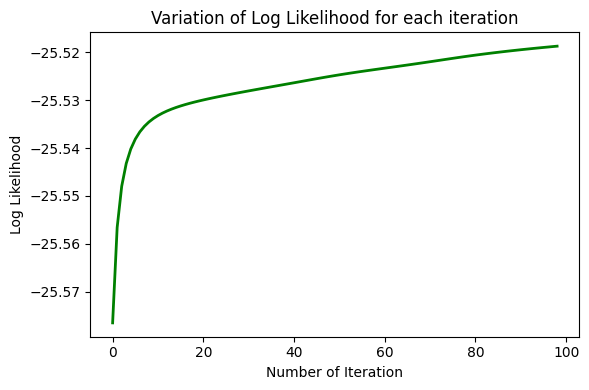

GMM Model for Gujrati => AIC: 179.03721380700426, BIC: 742.3066308926382
Gujrati is done
Average time per iteration: 1.3800 seconds


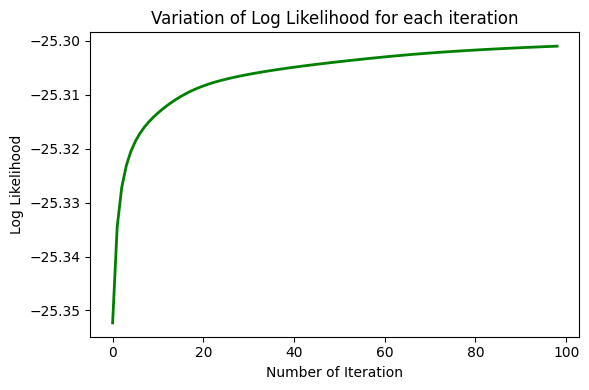

GMM Model for Tamil => AIC: 178.60194650790203, BIC: 748.9391281381739
Tamil is done
Average time per iteration: 1.1237 seconds


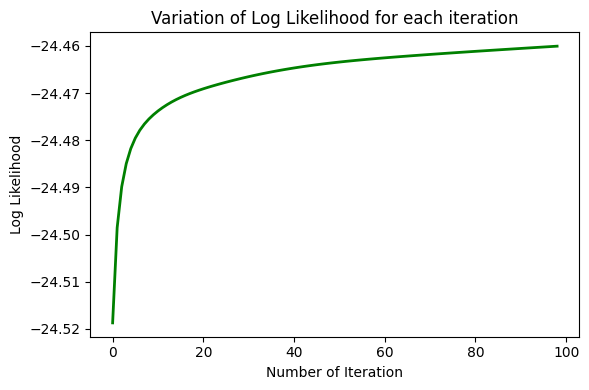

GMM Model for Telugu => AIC: 176.9200050292717, BIC: 732.9786268669329
Telugu is done


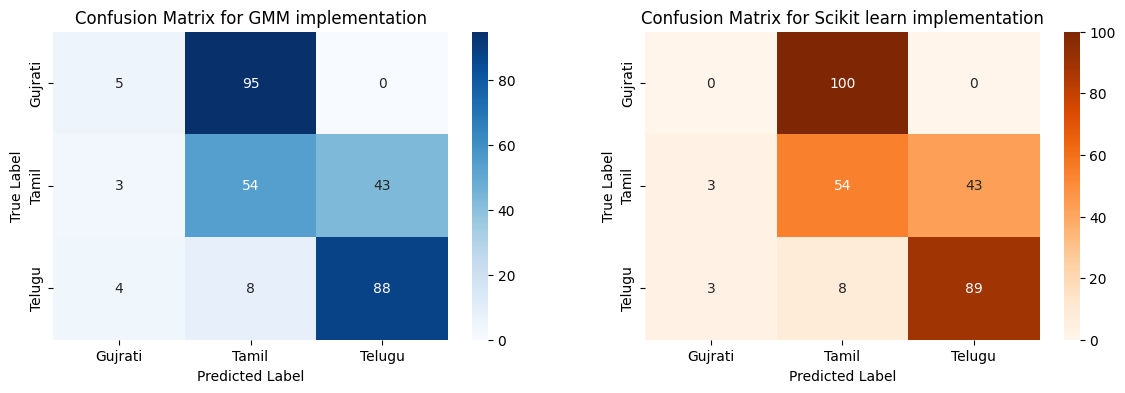

GMM Implementation Metrics:
Overall Accuracy: 49.00%
F1 Score of Gujrati: 0.08928571428571429
F1 Score of Tamil: 0.42023346303501946
F1 Score of Telugu: 0.7619047619047619

Scikit-learn's GMM Metrics:
Overall Accuracy: 47.67%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4122137404580153
F1 Score of Telugu: 0.7672413793103449
Num comp:32, Num PCA:13
Average time per iteration: 0.9268 seconds


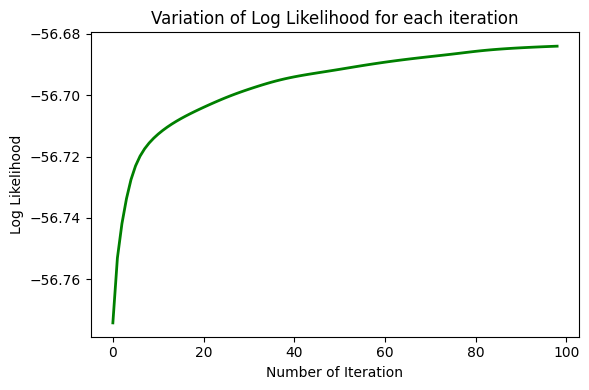

GMM Model for Gujrati => AIC: 177.3679698371193, BIC: 459.00267837993624
Gujrati is done
Average time per iteration: 1.0220 seconds


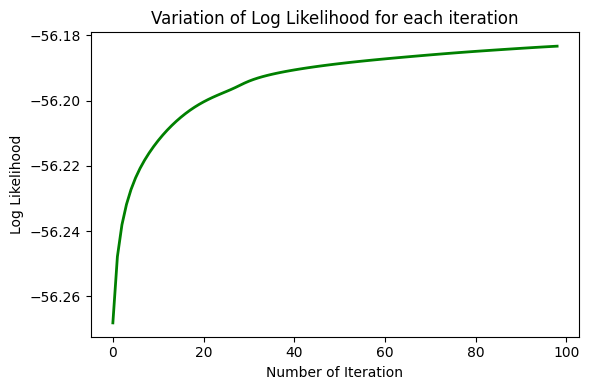

GMM Model for Tamil => AIC: 176.3664669441631, BIC: 461.5350577592991
Tamil is done
Average time per iteration: 0.8524 seconds


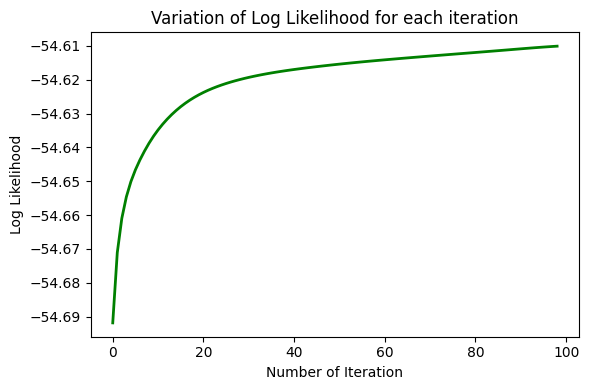

GMM Model for Telugu => AIC: 173.22001189323555, BIC: 451.24932281206617
Telugu is done


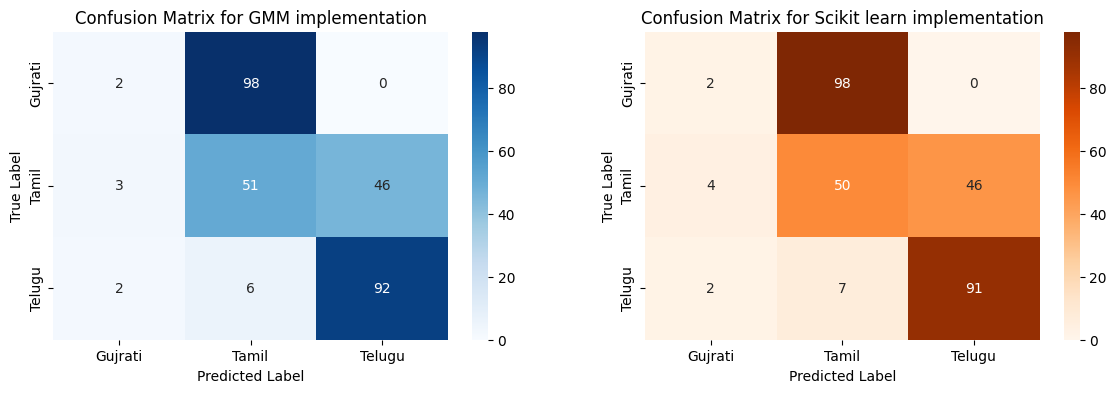

GMM Implementation Metrics:
Overall Accuracy: 48.33%
F1 Score of Gujrati: 0.037383177570093455
F1 Score of Tamil: 0.39999999999999997
F1 Score of Telugu: 0.7731092436974789

Scikit-learn's GMM Metrics:
Overall Accuracy: 47.67%
F1 Score of Gujrati: 0.037037037037037035
F1 Score of Tamil: 0.39215686274509803
F1 Score of Telugu: 0.7679324894514769
Num comp:64, Num PCA:13
Average time per iteration: 1.8207 seconds


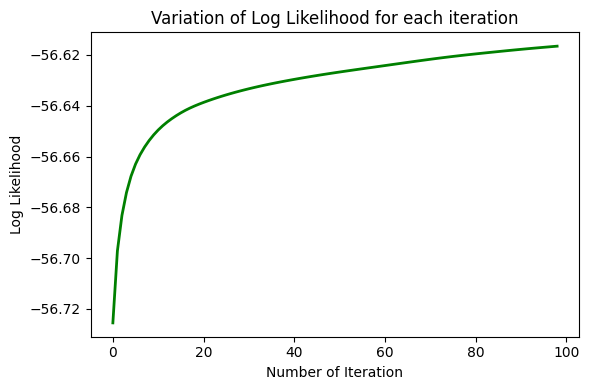

GMM Model for Gujrati => AIC: 241.232856620721, BIC: 804.5022737063549
Gujrati is done
Average time per iteration: 2.0382 seconds


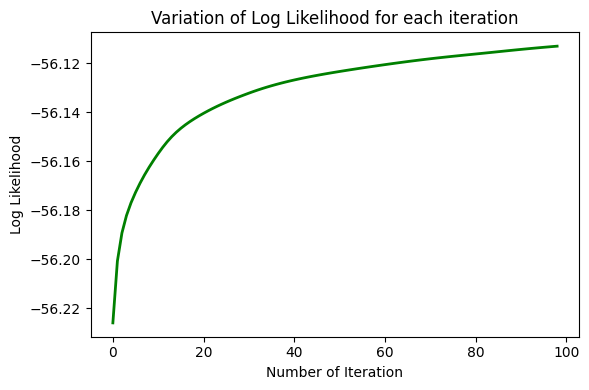

GMM Model for Tamil => AIC: 240.22585668376735, BIC: 810.5630383140393
Tamil is done
Average time per iteration: 1.6460 seconds


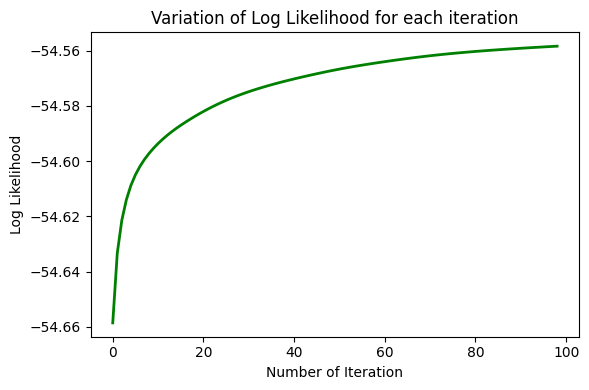

GMM Model for Telugu => AIC: 237.11663417955853, BIC: 793.1752560172198
Telugu is done


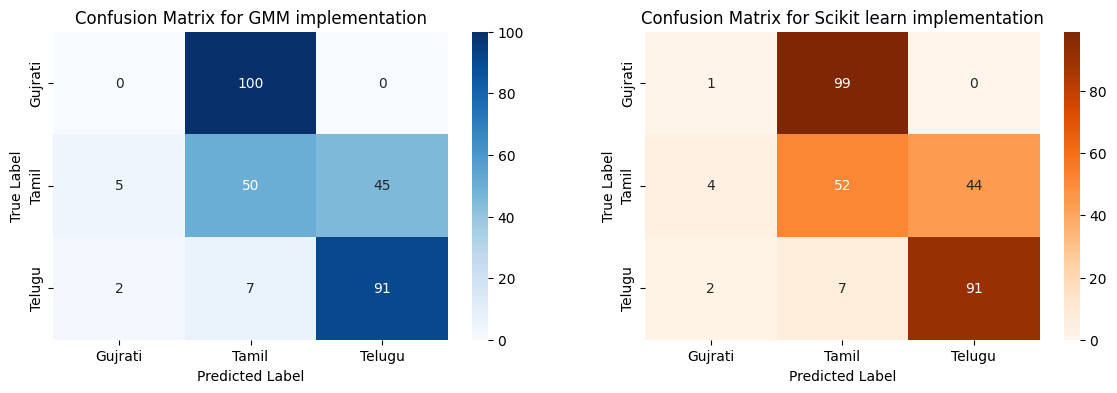

GMM Implementation Metrics:
Overall Accuracy: 47.00%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.38910505836575876
F1 Score of Telugu: 0.771186440677966

Scikit-learn's GMM Metrics:
Overall Accuracy: 48.00%
F1 Score of Gujrati: 0.018691588785046728
F1 Score of Tamil: 0.40310077519379844
F1 Score of Telugu: 0.7744680851063829
Num comp:32, Num PCA:24
Average time per iteration: 1.2802 seconds


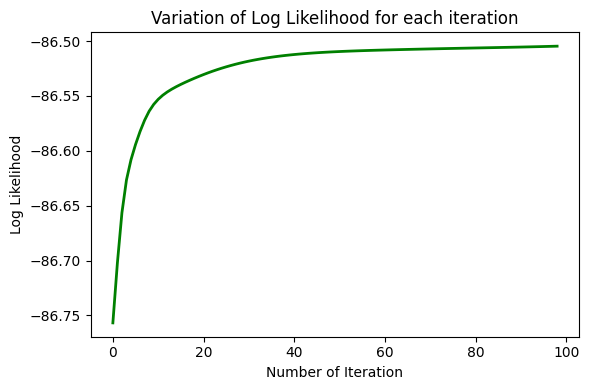

GMM Model for Gujrati => AIC: 237.0091446848656, BIC: 518.6438532276825
Gujrati is done
Average time per iteration: 1.3860 seconds


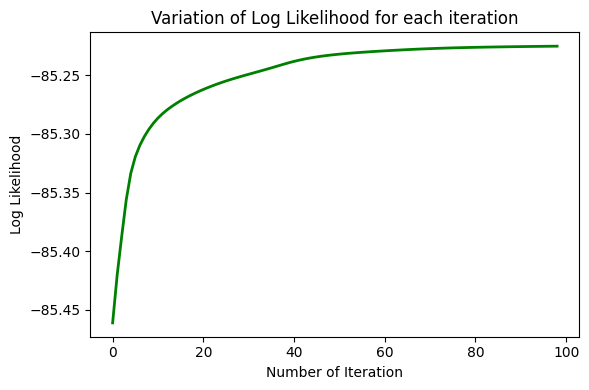

GMM Model for Tamil => AIC: 234.45007820570763, BIC: 519.6186690208436
Tamil is done
Average time per iteration: 1.1466 seconds


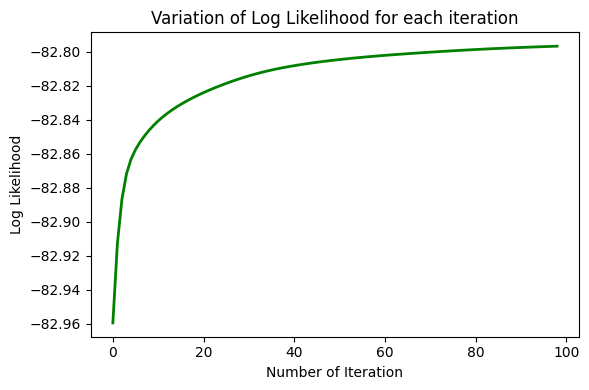

GMM Model for Telugu => AIC: 229.5934156751753, BIC: 507.62272659400594
Telugu is done


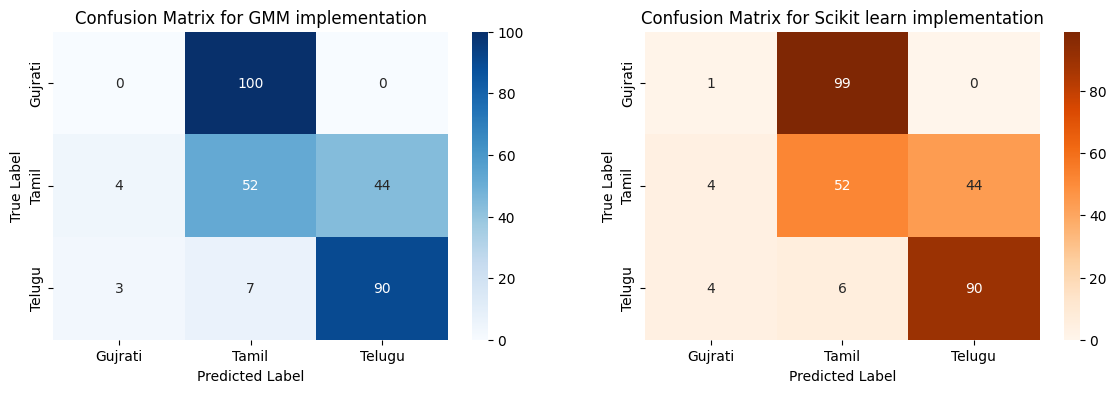

GMM Implementation Metrics:
Overall Accuracy: 47.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4015444015444016
F1 Score of Telugu: 0.7692307692307693

Scikit-learn's GMM Metrics:
Overall Accuracy: 47.67%
F1 Score of Gujrati: 0.01834862385321101
F1 Score of Tamil: 0.4046692607003891
F1 Score of Telugu: 0.7692307692307693
Num comp:64, Num PCA:24
Average time per iteration: 2.5141 seconds


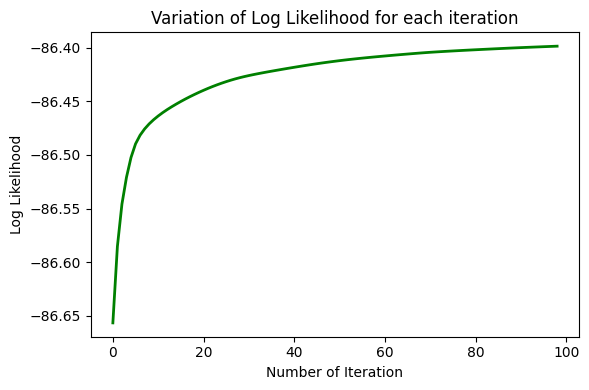

GMM Model for Gujrati => AIC: 300.7964473841929, BIC: 864.0658644698268
Gujrati is done
Average time per iteration: 2.7872 seconds


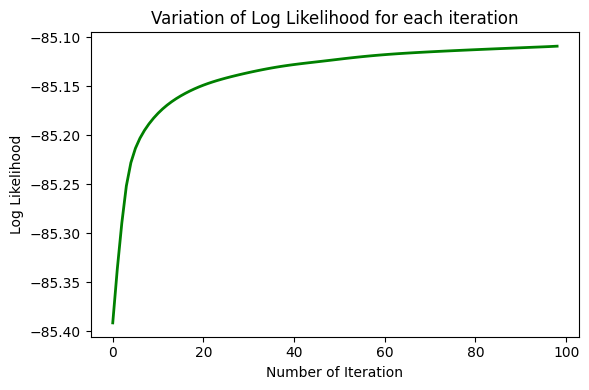

GMM Model for Tamil => AIC: 298.21728815958954, BIC: 868.5544697898615
Tamil is done
Average time per iteration: 2.2187 seconds


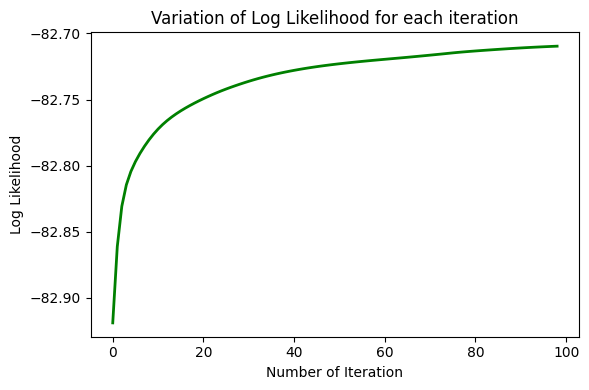

GMM Model for Telugu => AIC: 293.4189903223828, BIC: 849.477612160044
Telugu is done


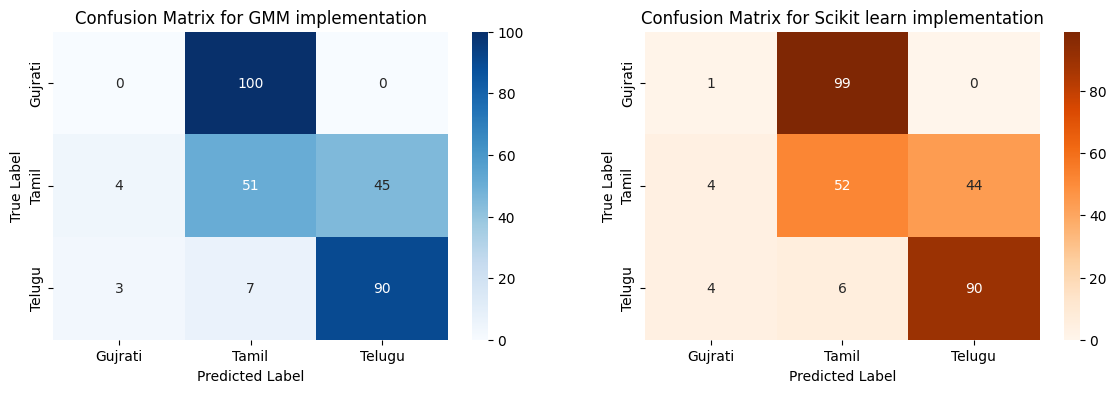

GMM Implementation Metrics:
Overall Accuracy: 47.00%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.39534883720930236
F1 Score of Telugu: 0.7659574468085106

Scikit-learn's GMM Metrics:
Overall Accuracy: 47.67%
F1 Score of Gujrati: 0.01834862385321101
F1 Score of Tamil: 0.4046692607003891
F1 Score of Telugu: 0.7692307692307693
Num comp:32, Num PCA:39
Average time per iteration: 3.8808 seconds


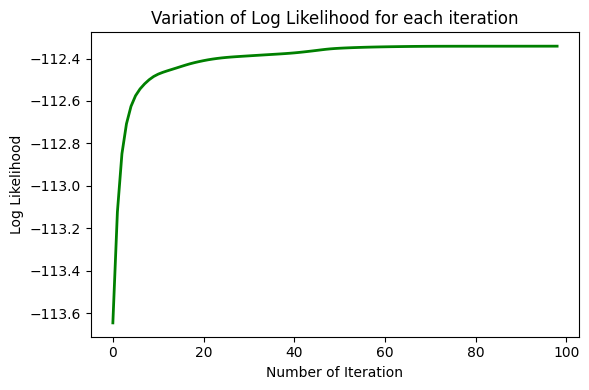

GMM Model for Gujrati => AIC: 288.68305200894656, BIC: 570.3177605517635
Gujrati is done
Average time per iteration: 4.1887 seconds


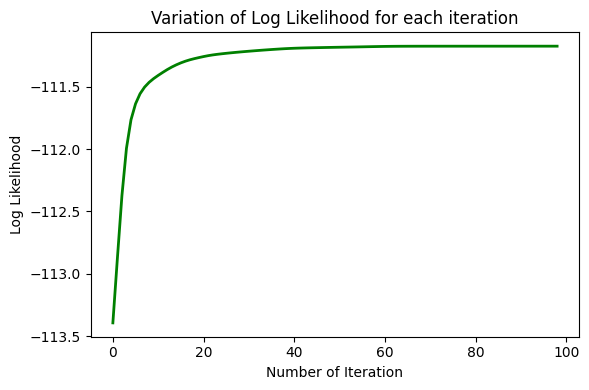

GMM Model for Tamil => AIC: 286.3478280579372, BIC: 571.5164188730732
Tamil is done
Average time per iteration: 2.4331 seconds


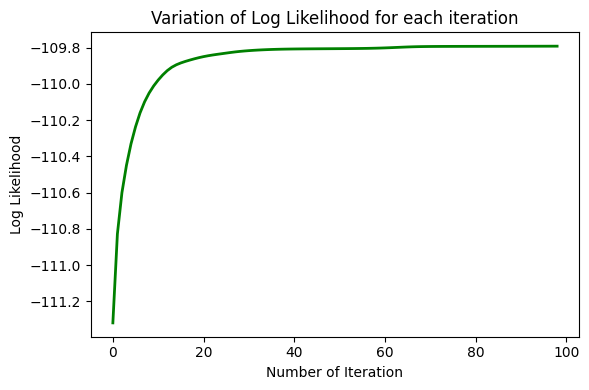

GMM Model for Telugu => AIC: 283.5821031569198, BIC: 561.6114140757504
Telugu is done


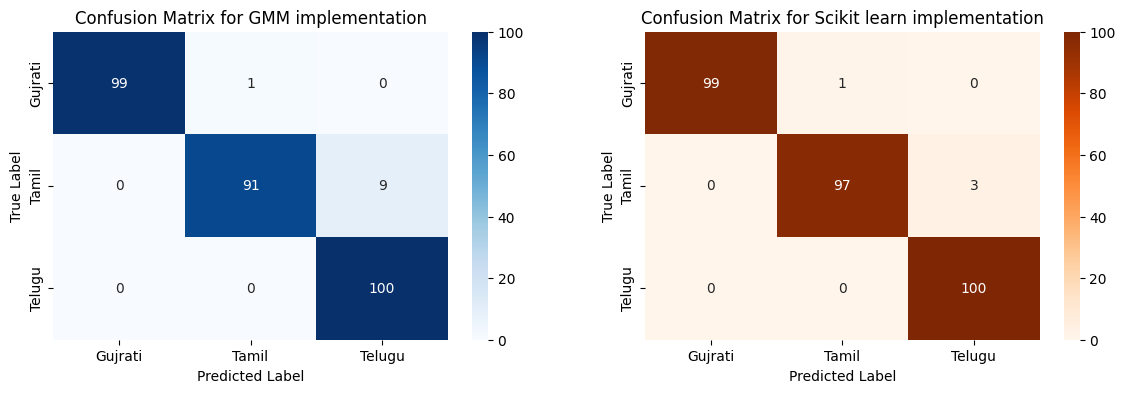

GMM Implementation Metrics:
Overall Accuracy: 96.67%
F1 Score of Gujrati: 0.9949748743718593
F1 Score of Tamil: 0.9479166666666667
F1 Score of Telugu: 0.9569377990430622

Scikit-learn's GMM Metrics:
Overall Accuracy: 98.67%
F1 Score of Gujrati: 0.9949748743718593
F1 Score of Tamil: 0.9797979797979798
F1 Score of Telugu: 0.9852216748768473
Num comp:64, Num PCA:39
Average time per iteration: 6.7774 seconds


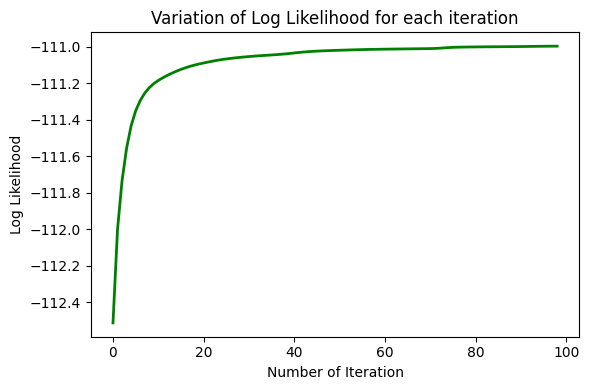

GMM Model for Gujrati => AIC: 349.99219021751264, BIC: 913.2616073031465
Gujrati is done
Average time per iteration: 7.4646 seconds


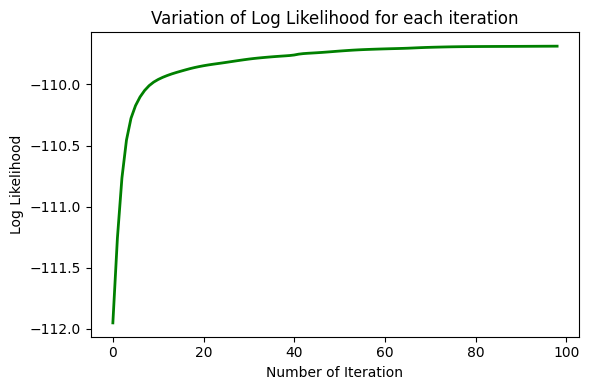

GMM Model for Tamil => AIC: 347.37446191321857, BIC: 917.7116435434905
Tamil is done
Average time per iteration: 4.9381 seconds


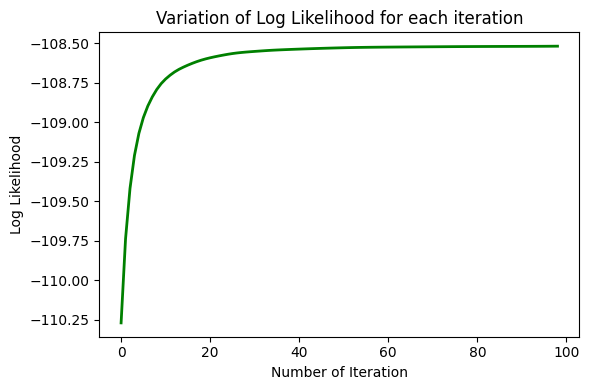

GMM Model for Telugu => AIC: 345.03685256367487, BIC: 901.0954744013361
Telugu is done


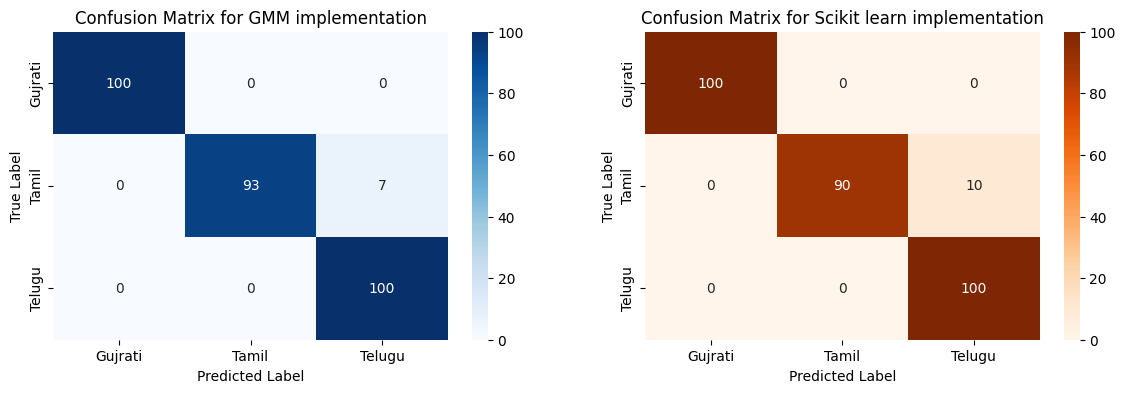

GMM Implementation Metrics:
Overall Accuracy: 97.67%
F1 Score of Gujrati: 1.0
F1 Score of Tamil: 0.9637305699481865
F1 Score of Telugu: 0.966183574879227

Scikit-learn's GMM Metrics:
Overall Accuracy: 96.67%
F1 Score of Gujrati: 1.0
F1 Score of Tamil: 0.9473684210526316
F1 Score of Telugu: 0.9523809523809523


In [13]:
import warnings
warnings.filterwarnings("ignore")

n_comp_list = [32,64]
num_pca_list = [3,5,13,24,39]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand,'diag')

Num comp:32, Num PCA:3
Average time per iteration: 0.5498 seconds


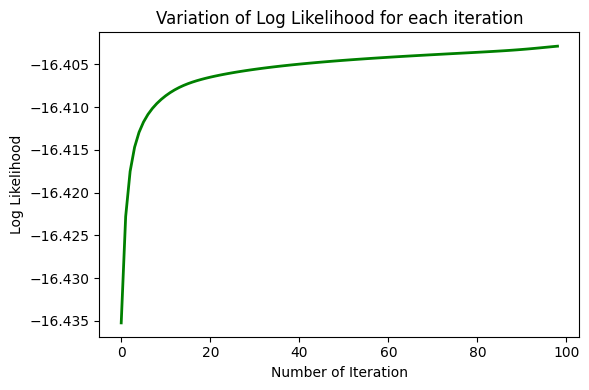

GMM Model for Gujrati => AIC: 96.80563440725228, BIC: 378.44034295006924
Gujrati is done
Average time per iteration: 0.6422 seconds


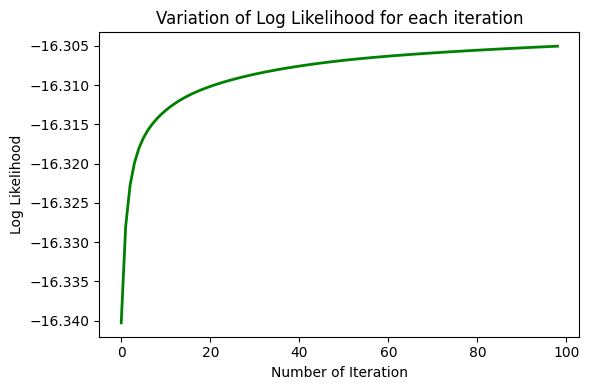

GMM Model for Tamil => AIC: 96.61004573642242, BIC: 381.7786365515584
Tamil is done
Average time per iteration: 0.5055 seconds


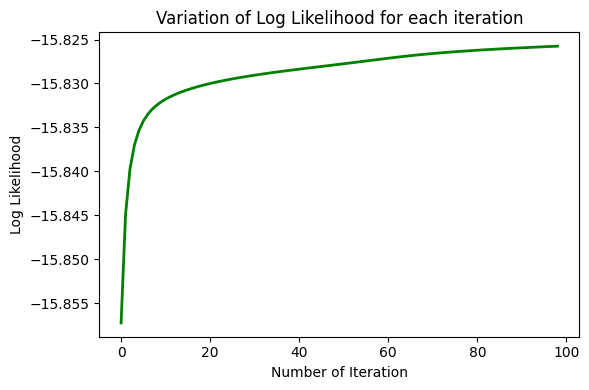

GMM Model for Telugu => AIC: 95.65146024734665, BIC: 373.68077116617724
Telugu is done


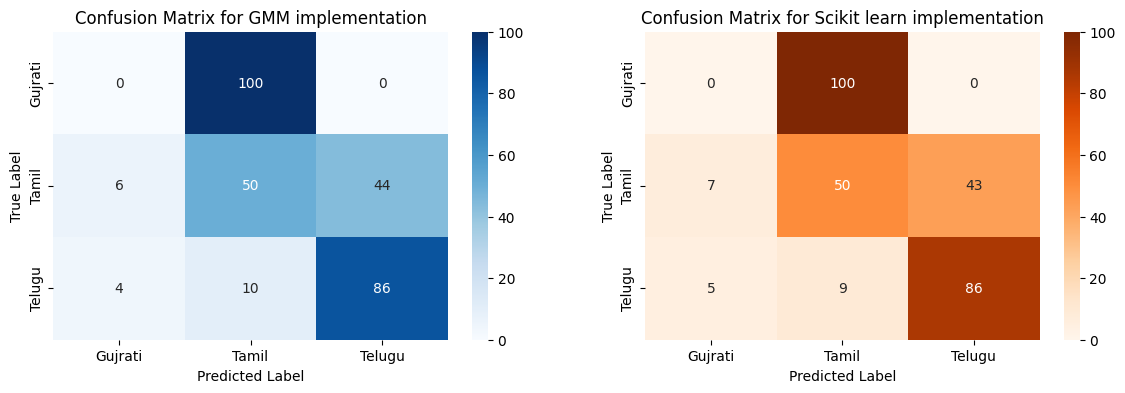

GMM Implementation Metrics:
Overall Accuracy: 45.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.38461538461538464
F1 Score of Telugu: 0.7478260869565216

Scikit-learn's GMM Metrics:
Overall Accuracy: 45.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.3861003861003861
F1 Score of Telugu: 0.7510917030567684
Num comp:64, Num PCA:3
Average time per iteration: 1.0658 seconds


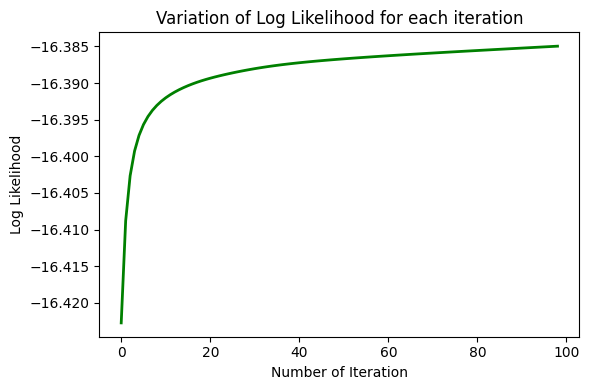

GMM Model for Gujrati => AIC: 160.7698603262395, BIC: 724.0392774118734
Gujrati is done
Average time per iteration: 1.1989 seconds


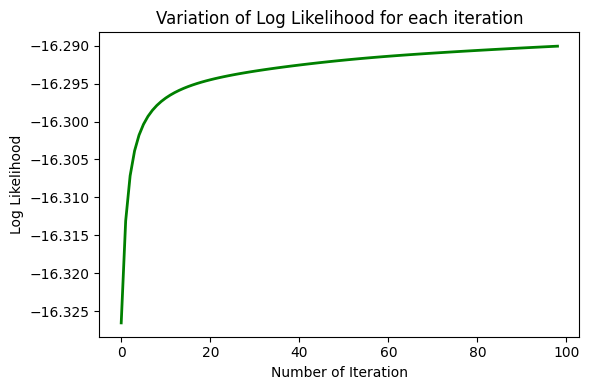

GMM Model for Tamil => AIC: 160.58004453310588, BIC: 730.9172261633778
Tamil is done
Average time per iteration: 0.9606 seconds


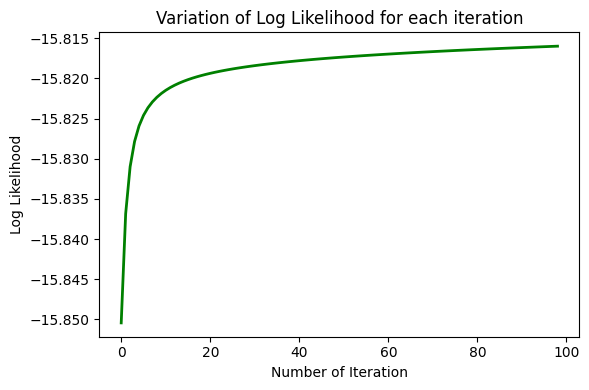

GMM Model for Telugu => AIC: 159.63192533969217, BIC: 715.6905471773534
Telugu is done


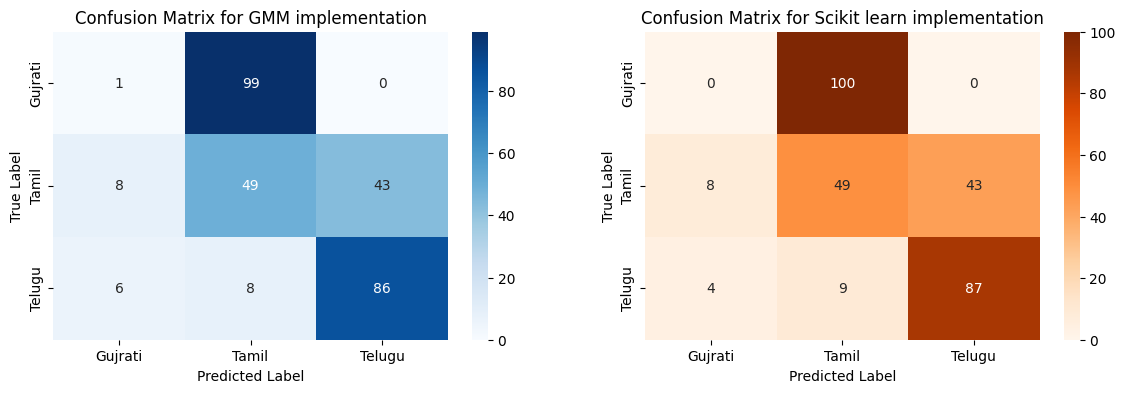

GMM Implementation Metrics:
Overall Accuracy: 45.33%
F1 Score of Gujrati: 0.017391304347826087
F1 Score of Tamil: 0.3828125
F1 Score of Telugu: 0.7510917030567684

Scikit-learn's GMM Metrics:
Overall Accuracy: 45.33%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.3798449612403101
F1 Score of Telugu: 0.7565217391304347
Num comp:32, Num PCA:5
Average time per iteration: 0.6660 seconds


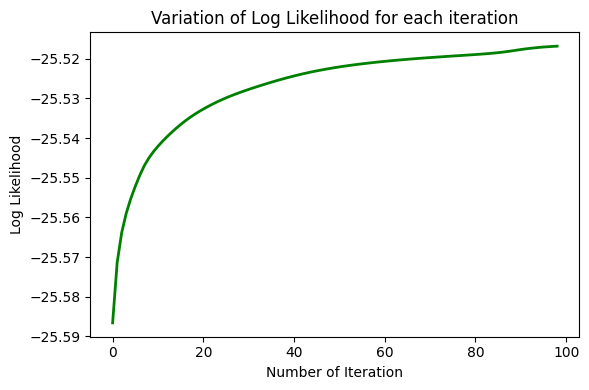

GMM Model for Gujrati => AIC: 115.0335391398593, BIC: 396.6682476826763
Gujrati is done
Average time per iteration: 0.7185 seconds


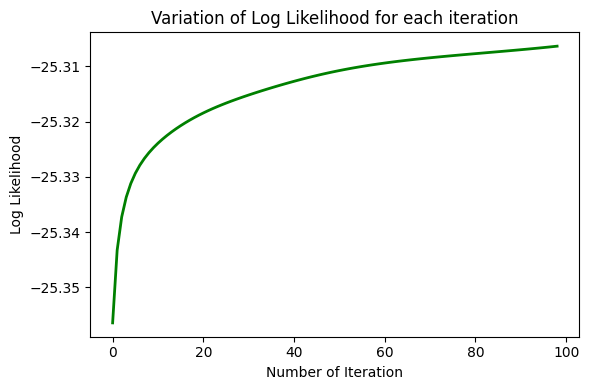

GMM Model for Tamil => AIC: 114.61255382718022, BIC: 399.78114464231624
Tamil is done
Average time per iteration: 0.5983 seconds


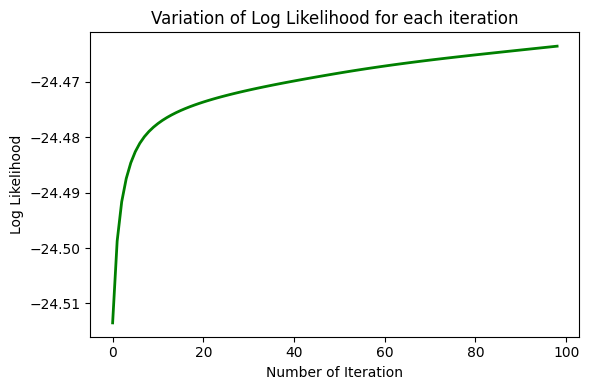

GMM Model for Telugu => AIC: 112.92697769310871, BIC: 390.9562886119393
Telugu is done


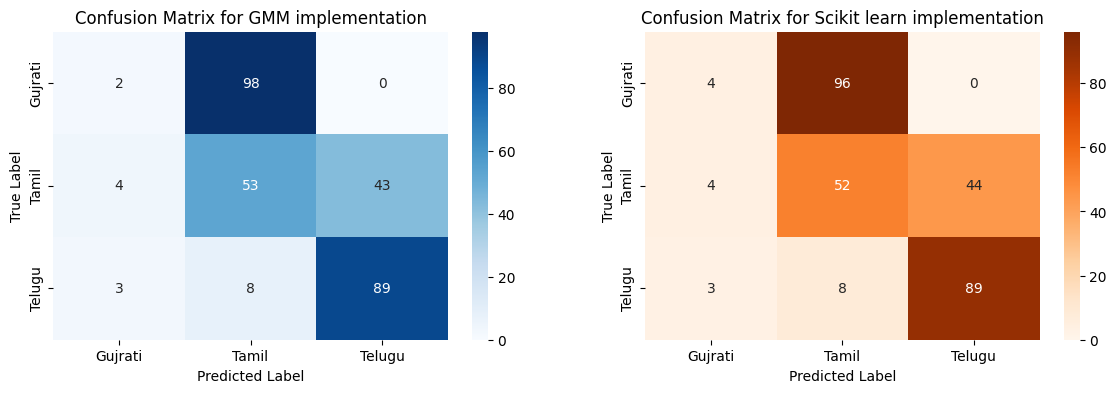

GMM Implementation Metrics:
Overall Accuracy: 48.00%
F1 Score of Gujrati: 0.03669724770642202
F1 Score of Tamil: 0.4092664092664093
F1 Score of Telugu: 0.7672413793103449

Scikit-learn's GMM Metrics:
Overall Accuracy: 48.33%
F1 Score of Gujrati: 0.07207207207207207
F1 Score of Tamil: 0.40625000000000006
F1 Score of Telugu: 0.7639484978540773
Num comp:64, Num PCA:5
Average time per iteration: 1.2417 seconds


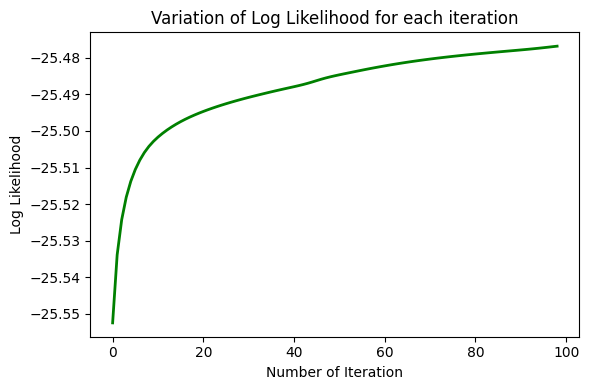

GMM Model for Gujrati => AIC: 178.95336154911487, BIC: 742.2227786347488
Gujrati is done
Average time per iteration: 1.3681 seconds


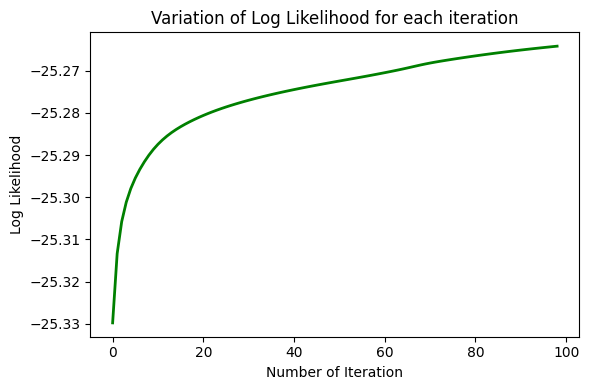

GMM Model for Tamil => AIC: 178.52821734218372, BIC: 748.8653989724558
Tamil is done
Average time per iteration: 1.1285 seconds


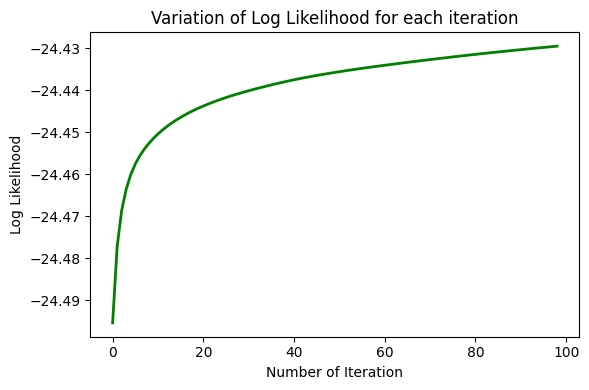

GMM Model for Telugu => AIC: 176.85889865471412, BIC: 732.9175204923754
Telugu is done


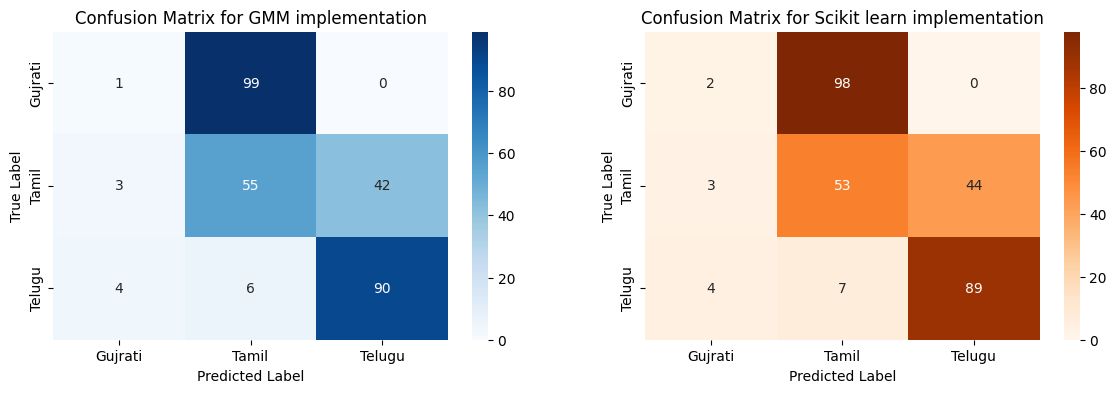

GMM Implementation Metrics:
Overall Accuracy: 48.67%
F1 Score of Gujrati: 0.018518518518518517
F1 Score of Tamil: 0.42307692307692313
F1 Score of Telugu: 0.7758620689655172

Scikit-learn's GMM Metrics:
Overall Accuracy: 48.00%
F1 Score of Gujrati: 0.03669724770642202
F1 Score of Tamil: 0.4108527131782946
F1 Score of Telugu: 0.7639484978540773
Num comp:32, Num PCA:13
Average time per iteration: 1.1851 seconds


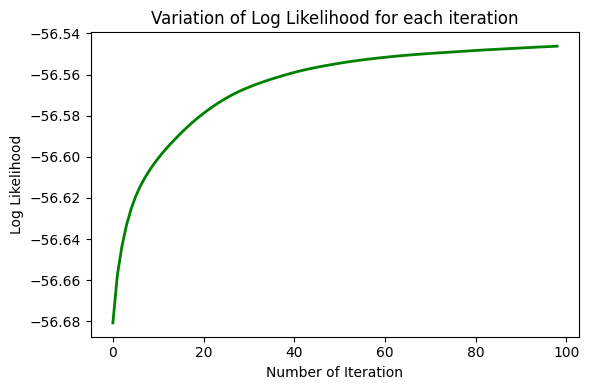

GMM Model for Gujrati => AIC: 177.09216779054572, BIC: 458.72687633336267
Gujrati is done
Average time per iteration: 1.3043 seconds


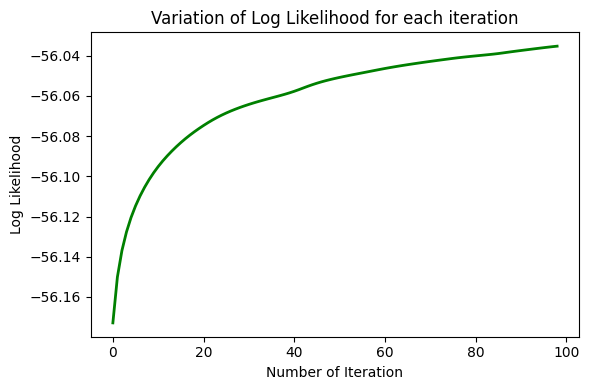

GMM Model for Tamil => AIC: 176.06998026752927, BIC: 461.23857108266526
Tamil is done
Average time per iteration: 1.0544 seconds


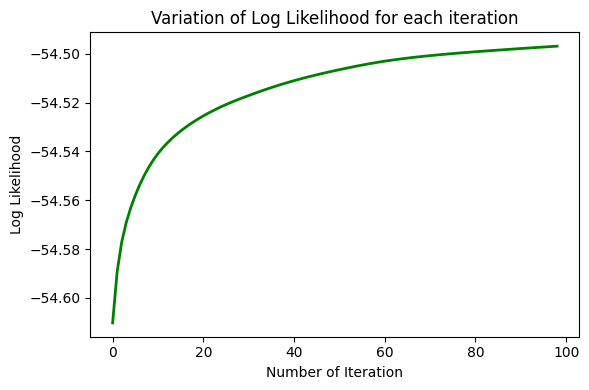

GMM Model for Telugu => AIC: 172.993434894246, BIC: 451.02274581307665
Telugu is done


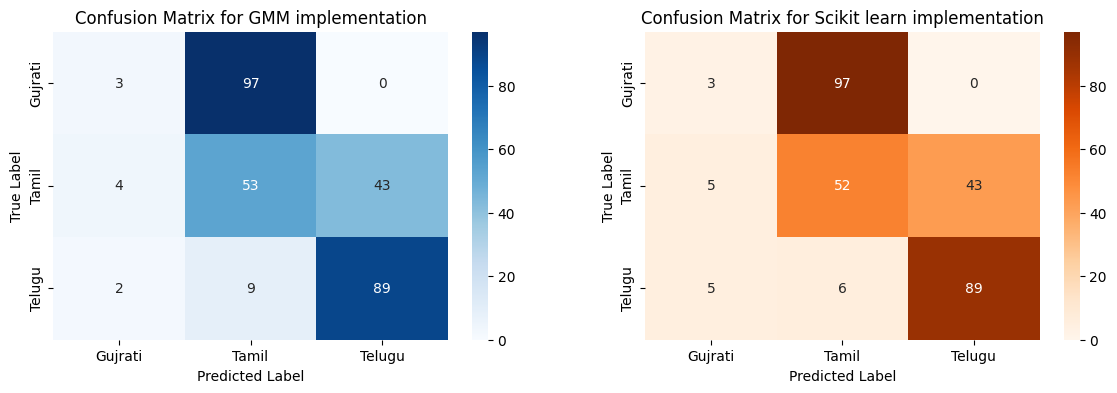

GMM Implementation Metrics:
Overall Accuracy: 48.33%
F1 Score of Gujrati: 0.055045871559633024
F1 Score of Tamil: 0.4092664092664093
F1 Score of Telugu: 0.7672413793103449

Scikit-learn's GMM Metrics:
Overall Accuracy: 48.00%
F1 Score of Gujrati: 0.05309734513274337
F1 Score of Tamil: 0.407843137254902
F1 Score of Telugu: 0.7672413793103449
Num comp:64, Num PCA:13
Average time per iteration: 2.3433 seconds


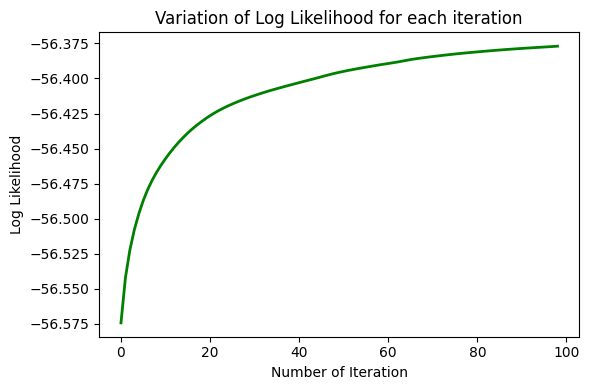

GMM Model for Gujrati => AIC: 240.75348759284105, BIC: 804.0229046784749
Gujrati is done
Average time per iteration: 2.6686 seconds


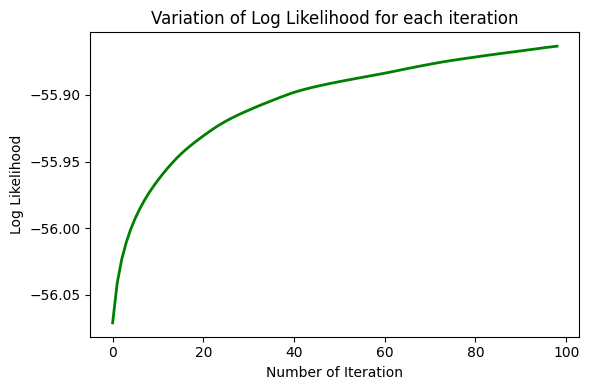

GMM Model for Tamil => AIC: 239.72595956426363, BIC: 810.0631411945355
Tamil is done
Average time per iteration: 2.0865 seconds


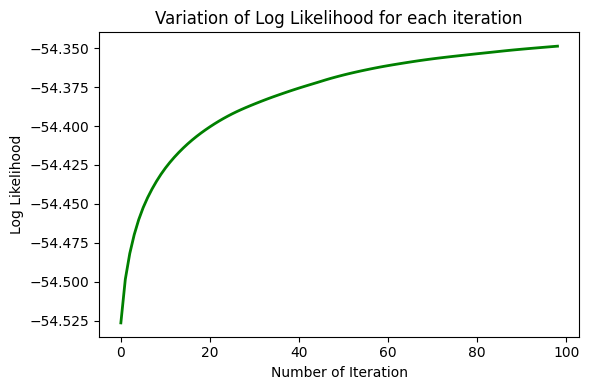

GMM Model for Telugu => AIC: 236.69699912275956, BIC: 792.7556209604207
Telugu is done


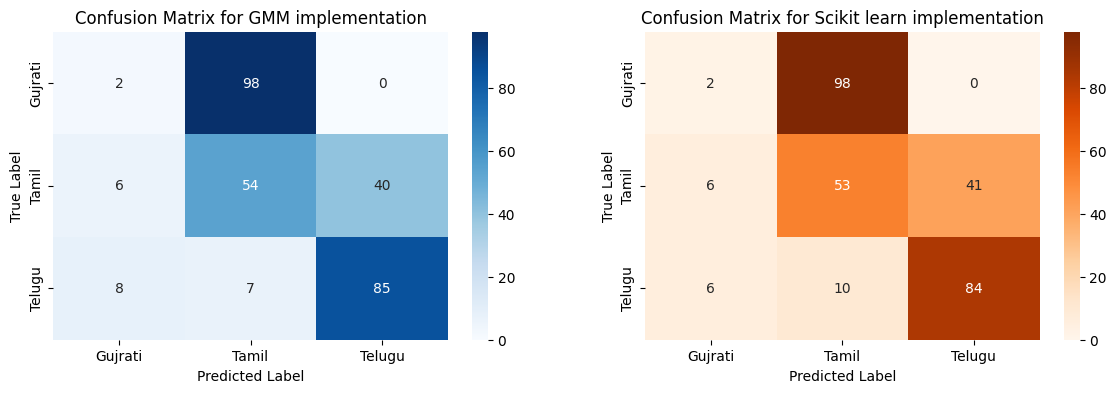

GMM Implementation Metrics:
Overall Accuracy: 47.00%
F1 Score of Gujrati: 0.03448275862068966
F1 Score of Tamil: 0.41698841698841704
F1 Score of Telugu: 0.7555555555555556

Scikit-learn's GMM Metrics:
Overall Accuracy: 46.33%
F1 Score of Gujrati: 0.03508771929824562
F1 Score of Tamil: 0.4061302681992337
F1 Score of Telugu: 0.7466666666666666
Num comp:32, Num PCA:24
Average time per iteration: 1.9964 seconds


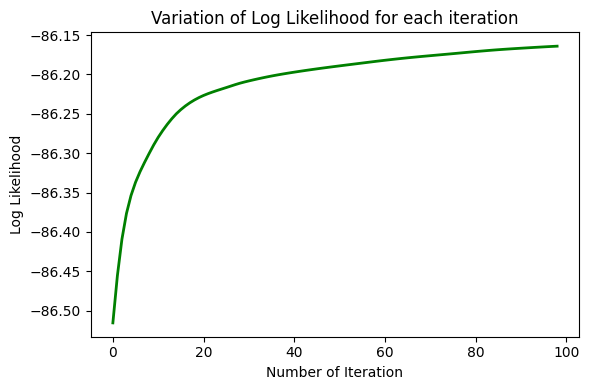

GMM Model for Gujrati => AIC: 236.32769894051836, BIC: 517.9624074833353
Gujrati is done
Average time per iteration: 2.2504 seconds


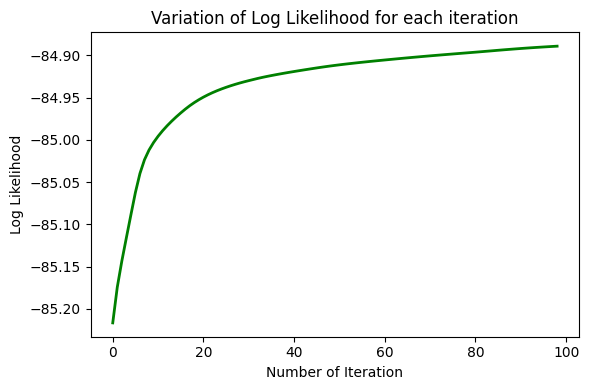

GMM Model for Tamil => AIC: 233.77792786268463, BIC: 518.9465186778207
Tamil is done
Average time per iteration: 1.8418 seconds


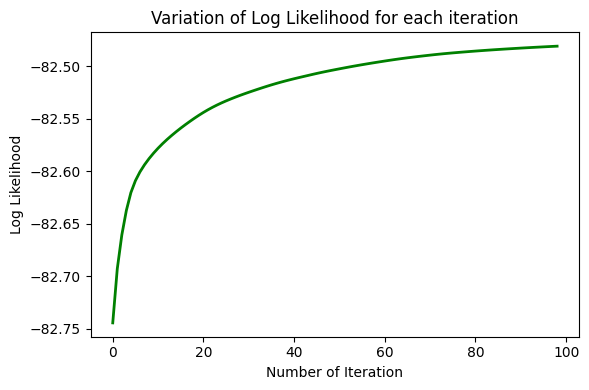

GMM Model for Telugu => AIC: 228.96087102564334, BIC: 506.990181944474
Telugu is done


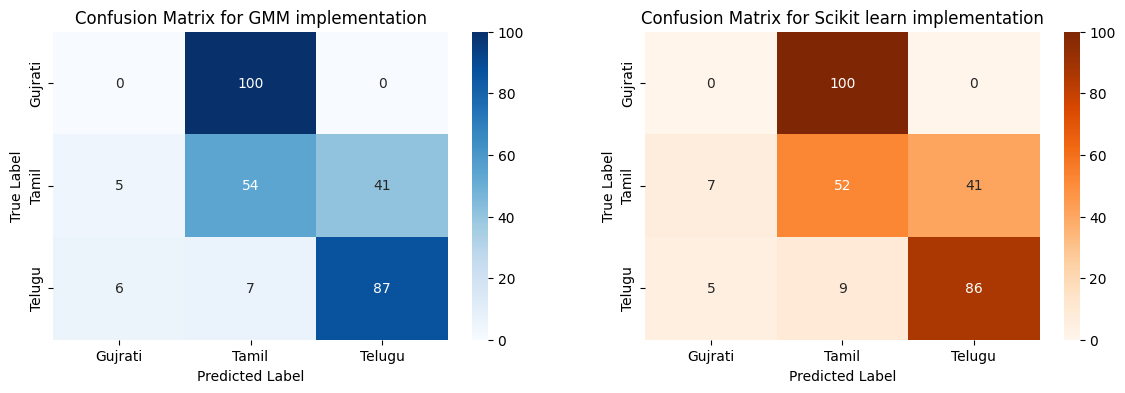

GMM Implementation Metrics:
Overall Accuracy: 47.00%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4137931034482759
F1 Score of Telugu: 0.763157894736842

Scikit-learn's GMM Metrics:
Overall Accuracy: 46.00%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.3984674329501916
F1 Score of Telugu: 0.7577092511013216
Num comp:64, Num PCA:24
Average time per iteration: 4.1675 seconds


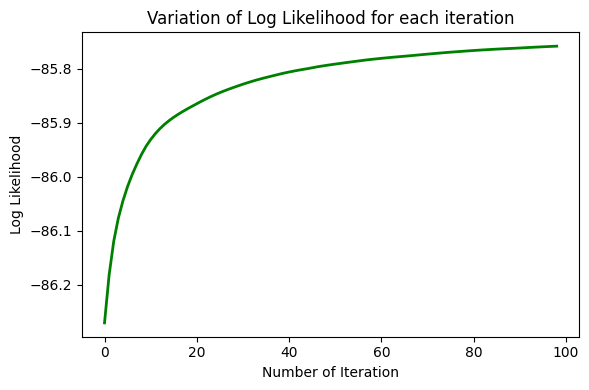

GMM Model for Gujrati => AIC: 299.51530859775687, BIC: 862.7847256833908
Gujrati is done
Average time per iteration: 4.5534 seconds


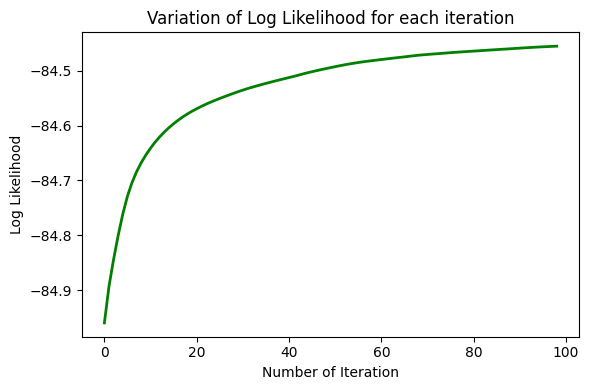

GMM Model for Tamil => AIC: 296.91006834209895, BIC: 867.2472499723709
Tamil is done
Average time per iteration: 3.6802 seconds


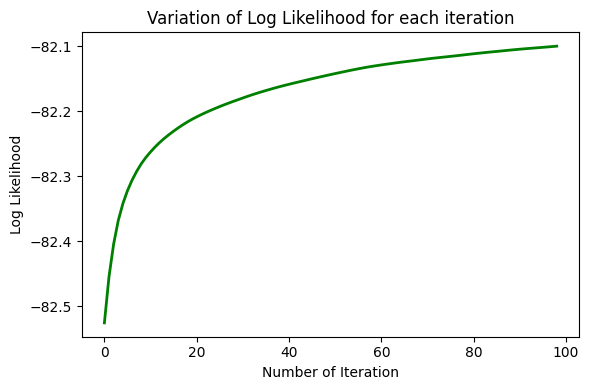

GMM Model for Telugu => AIC: 292.1992895247171, BIC: 848.2579113623783
Telugu is done


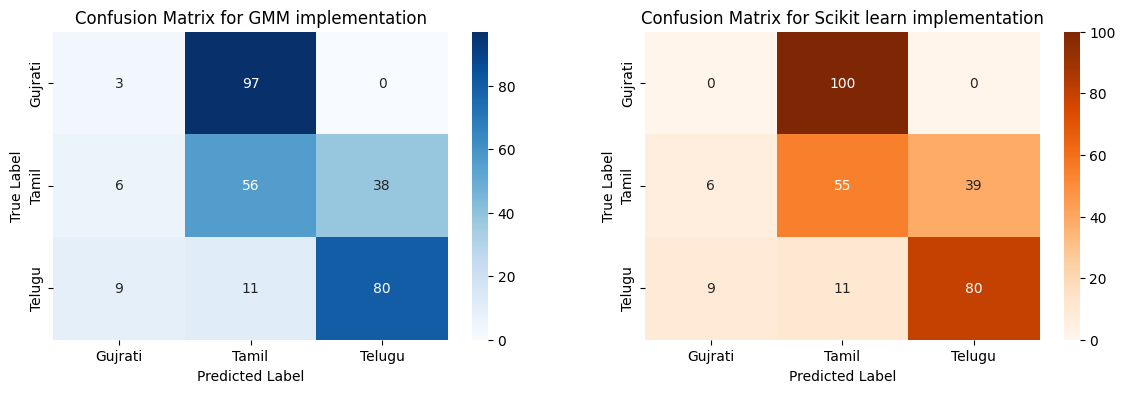

GMM Implementation Metrics:
Overall Accuracy: 46.33%
F1 Score of Gujrati: 0.05084745762711864
F1 Score of Tamil: 0.42424242424242425
F1 Score of Telugu: 0.7339449541284404

Scikit-learn's GMM Metrics:
Overall Accuracy: 45.00%
F1 Score of Gujrati: 0
F1 Score of Tamil: 0.4135338345864662
F1 Score of Telugu: 0.7305936073059361
Num comp:32, Num PCA:39
Average time per iteration: 4.5454 seconds


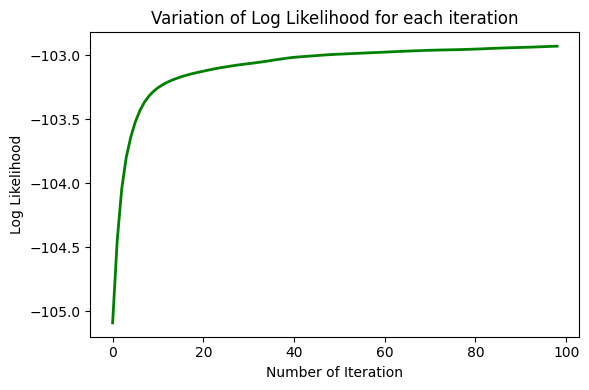

GMM Model for Gujrati => AIC: 269.8545045642212, BIC: 551.4892131070382
Gujrati is done
Average time per iteration: 4.9030 seconds


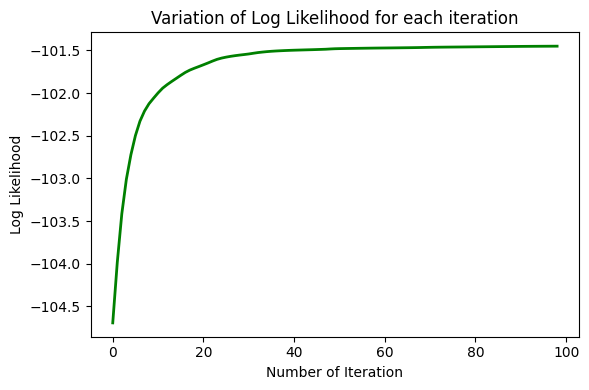

GMM Model for Tamil => AIC: 266.90033329222354, BIC: 552.0689241073595
Tamil is done
Average time per iteration: 3.0717 seconds


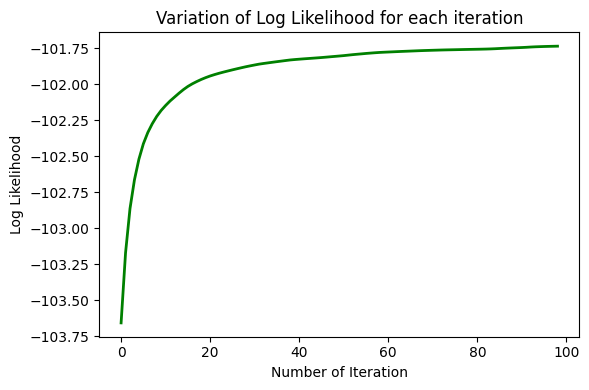

GMM Model for Telugu => AIC: 267.4695475144124, BIC: 545.4988584332431
Telugu is done


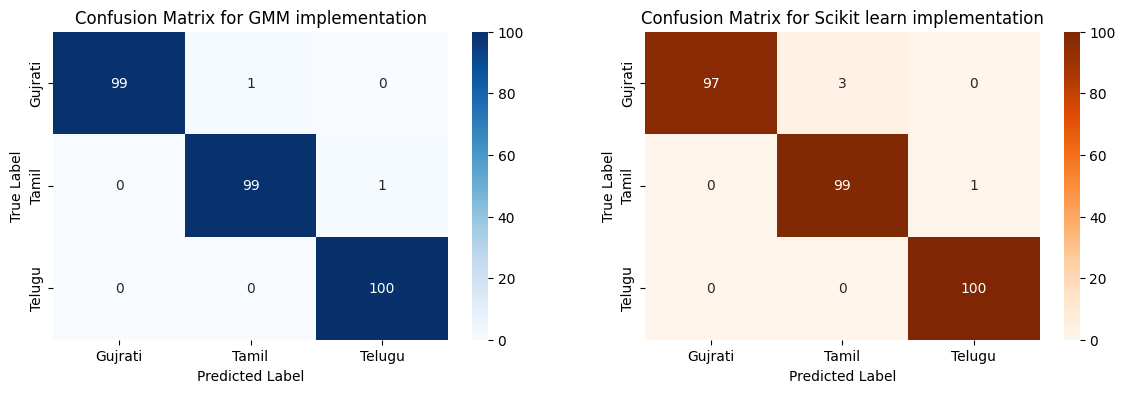

GMM Implementation Metrics:
Overall Accuracy: 99.33%
F1 Score of Gujrati: 0.9949748743718593
F1 Score of Tamil: 0.99
F1 Score of Telugu: 0.9950248756218906

Scikit-learn's GMM Metrics:
Overall Accuracy: 98.67%
F1 Score of Gujrati: 0.9847715736040609
F1 Score of Tamil: 0.9801980198019802
F1 Score of Telugu: 0.9950248756218906
Num comp:64, Num PCA:39
Average time per iteration: 8.1916 seconds


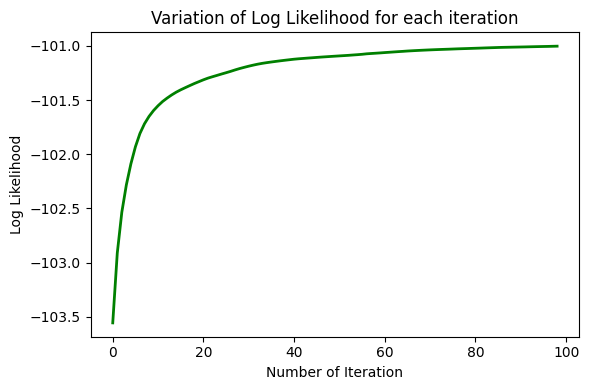

GMM Model for Gujrati => AIC: 330.00414464720586, BIC: 893.2735617328398
Gujrati is done
Average time per iteration: 9.1451 seconds


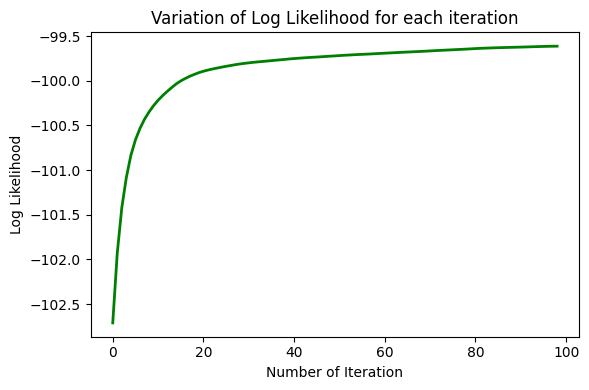

GMM Model for Tamil => AIC: 327.22550381541555, BIC: 897.5626854456875
Tamil is done
Average time per iteration: 5.9822 seconds


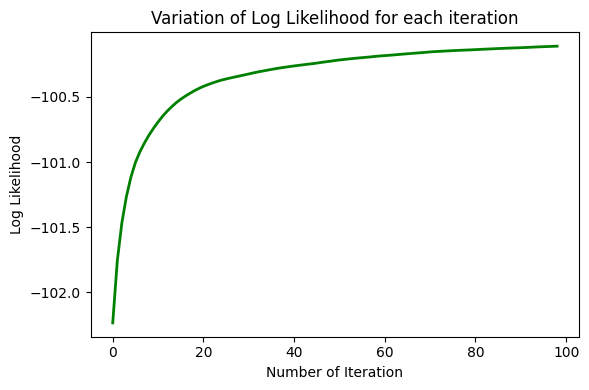

GMM Model for Telugu => AIC: 328.2190537026949, BIC: 884.2776755403561
Telugu is done


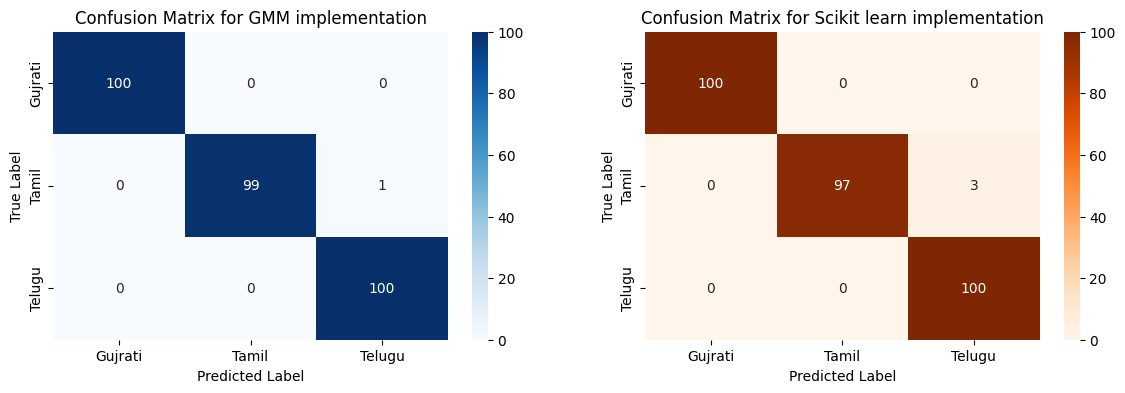

GMM Implementation Metrics:
Overall Accuracy: 99.67%
F1 Score of Gujrati: 1.0
F1 Score of Tamil: 0.9949748743718593
F1 Score of Telugu: 0.9950248756218906

Scikit-learn's GMM Metrics:
Overall Accuracy: 99.00%
F1 Score of Gujrati: 1.0
F1 Score of Tamil: 0.9847715736040609
F1 Score of Telugu: 0.9852216748768473


In [14]:
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand,'full')